In [1]:
# Python imports

import os
import pandas as pd
import time
import logging

# Module logger
log = logging.getLogger(__name__)

# For timing the run
start = time.time()

%matplotlib inline
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.workflow import execute_entity_task

# Initialize OGGM and set up the run parameters --> Read the configuration file containing the run’s parameters.
cfg.initialize(logging_level='WORKFLOW')

cfg.PARAMS['grid_dx_method'] = 'fixed'
cfg.PARAMS['fixed_dx'] = 30

2019-06-15 12:08:57: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/oggm/oggm/params.cfg


In [2]:
# Pre-download other files which will be needed later
utils.get_cru_cl_file()
utils.get_cru_file(var='tmp')
utils.get_cru_file(var='pre')

# Get the RGI glaciers for the run.
rgi_list = ['RGI60-02.07780', 'RGI60-02.01857', 'RGI60-02.02171', 'RGI60-02.04264', 'RGI60-02.03688', 'RGI60-02.00147']
rgidf = utils.get_rgi_glacier_entities(rgi_list)

In [3]:
cfg.PARAMS['grid_dx_method'] = 'fixed'
cfg.PARAMS['fixed_dx'] = 30

In [4]:
cfg.PARAMS['grid_dx_method']

'fixed'

In [5]:
# Local working directory (where OGGM will write its output)
## IMPORTANT: if using gettempdir('default'), cfg.PARAMS are overridden
WORKING_DIR = '/home/pelto/oggm_runs/CB_all_mbcal_30m_noprepro' 
utils.mkdir(WORKING_DIR, reset=True)
cfg.PATHS['working_dir'] = WORKING_DIR

# Use multiprocessing?
cfg.PARAMS['use_multiprocessing'] = True

# Go - initialize glacier directories
# We start at level 3, because we need all data for the inversion
gdirs = workflow.init_glacier_regions(rgidf, reset=True, force=True) #, from_prepro_level=3) 
#from_prepro_level=3, prepro will override cfg.params --at least for fixed_dx

# Preprocessing and climate tasks
task_list = [
    tasks.glacier_masks,
    tasks.compute_centerlines,
    tasks.initialize_flowlines,
    tasks.compute_downstream_line,
    tasks.compute_downstream_bedshape,
    tasks.catchment_area,
    tasks.catchment_intersections,
    tasks.catchment_width_geom,
    tasks.catchment_width_correction,
    tasks.process_cru_data,
#     tasks.local_t_star,
#     tasks.mu_star_calibration,
]
for task in task_list:
    execute_entity_task(task, gdirs)

2019-06-15 12:09:59: oggm.workflow: Execute entity task define_glacier_region on 6 glaciers
2019-06-15 12:09:59: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers()

In [6]:
cfg.PARAMS['grid_dx_method']

'fixed'

In [7]:
print(gdirs)

[<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.801 km2
  Lon, Lat: (-117.137, 49.749)
  Grid (nx, ny): (108, 103)
  Grid (dx, dy): (30.0, -30.0)
, <oggm.GlacierDirectory>
  RGI id: RGI60-02.01857
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 2.585 km2
  Lon, Lat: (-115.301, 50.7108)
  Grid (nx, ny): (103, 128)
  Grid (dx, dy): (30.0, -30.0)
, <oggm.GlacierDirectory>
  RGI id: RGI60-02.02171
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 16.898 km2
  Lon, Lat: (-116.93, 50.8069)
  Grid (nx, ny): (235, 278)
  Grid (dx, dy): (30.0, -30.0)
, <oggm.GlacierDirectory>
  RGI id: RGI60-02.03688
  Region: 02: Western Canada a

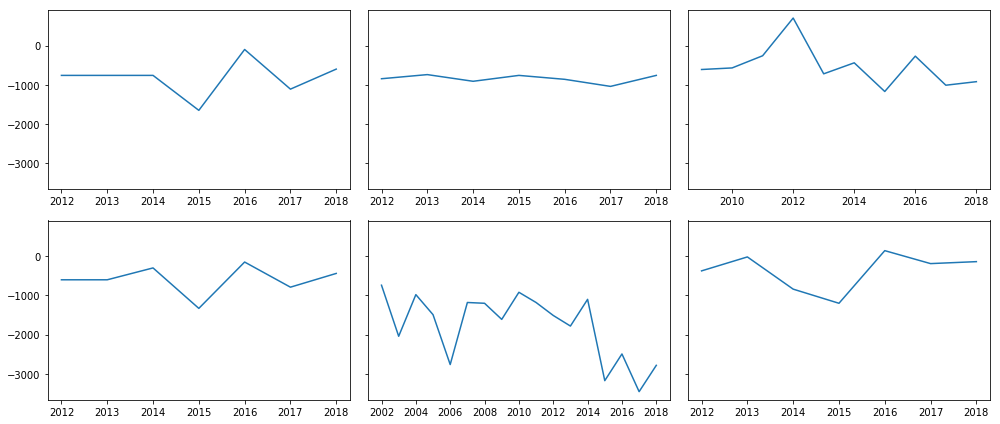

In [23]:
# This dataframe just needs some index and an 'ANN'

#conrad 2012, 2013, 2014 taken as 2015-2018 average
df = pd.DataFrame(index=range(2012, 2019)) 
df['ANNUAL_BALANCE'] = [-760, -760, -760, -1650, -100, -1110, -600]
# df.plot();

#zillmer 2012 taken as 2013-2018 average
df1 = pd.DataFrame(index=range(2012, 2019)) 
df1['ANNUAL_BALANCE'] = [-845, -740, -910, -760, -860, -1040, -760]
# df1.plot();

#illec, used geodetic for 2016-2018
df2 = pd.DataFrame(index=range(2009, 2019))
df2['ANNUAL_BALANCE'] = [-610, -570, -260, 700, -720, -440, -1170, -270, -1010, -920]
# df2.plot();

#nordic took 2012, 2013 as 2014-2018 average
df3 = pd.DataFrame(index=range(2012, 2019)) 
df3['ANNUAL_BALANCE'] = [-602, -602, -300, -1330, -150, -790, -440]
# df3.plot();

#Haig
df4 = pd.DataFrame(index=range(2002, 2019))
df4['ANNUAL_BALANCE'] = [-740, -2040, -980, -1490, -2760, -1180, -1200, -1610, -920, -1180, -1510, -1780, -1100, -3170, -2490, -3450, -2780]
# df4.plot();

#kokanee took 2012 as 2013-2018 average
df5 = pd.DataFrame(index=range(2012, 2019)) 
df5['ANNUAL_BALANCE'] = [-375, -20, -840, -1200, 140, -190, -140]
# df5.plot();

df_list = df, df1, df2, df3, df4, df5  

# Plot
f, axarr = plt.subplots(2, 3, sharey=True, figsize=(14, 6))

i, j = 0, 0
for val in range(6):
    axarr[i, j].plot(df_list[val])
   
    j += 1

    if val == 2: #changed to 2, 1 worked for 2x2 panel plot
        i += 1
        j = 0

plt.tight_layout()
# plt.savefig('xxx.png', dpi=600)
plt.show()

In [24]:
# Make sure the default list is generated
utils.get_ref_mb_glaciers_candidates(rgi_version='6');

# for gd in gdirs:
#     gd.set_ref_mb_data(df_list[0])
#     cfg.DATA['RGI60_ref_ids'].append(gd.rgi_id)

#i=5
#for i==0:

for i in range(6):
    gdir = gdirs[i]
    #gdir.set_ref_mb_data may be iterating over the same glacier as gdir. cannot be used for indexing...
    gdir.set_ref_mb_data(df_list[i])
    # Append our glaciers
    cfg.DATA['RGI60_ref_ids'].append(gdir.rgi_id)


In [25]:
#print(df_list[5])
#print(utils.get_ref_mb_glaciers(gdirs))

In [26]:
print(len(utils.get_ref_mb_glaciers(gdirs)))

6


In [27]:
# Make sure all three glaciers are now reference glaciers
assert len(utils.get_ref_mb_glaciers(gdirs)) == 6

In [28]:
 #re-run the calibration!
cfg.PARAMS['run_mb_calibration'] = True
tasks.compute_ref_t_stars(gdirs)
workflow.execute_entity_task(tasks.local_t_star, gdirs);
workflow.execute_entity_task(tasks.mu_star_calibration, gdirs);

2019-06-15 12:39:15: oggm.workflow: Execute entity task t_star_from_refmb on 6 glaciers
2019-06-15 12:39:15: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-06-15 12:39:16: oggm.workflow: Execute entity task local_t_star on 6 glaciers
2019-06-15 12:39:16: oggm.workflow: Execute entity task mu_star_calibration on 6 glaciers


**Note:** We asked OGGM to recalibrate its mass-balance model. In essence, it is as simple as computing a list of so-called "reference 𝑡∗ from which the model can interpolate from. This list is then written as CSV file in the working directory:

In [29]:
df_tstar = pd.read_csv(os.path.join(cfg.PATHS['working_dir'], 'ref_tstars.csv'), index_col=0)
df_tstar

,lon,lat,n_mb_years,tstar,bias
RGI60-02.00147,-117.137,49.7490,5,1978,2.249718
RGI60-02.01857,-115.301,50.7108,5,1961,267.002466
RGI60-02.02171,-116.930,50.8069,8,1999,-0.276860
RGI60-02.03688,-117.434,51.2370,5,2001,-296.017854
RGI60-02.04264,-117.710,51.4292,15,1961,675.610348
RGI60-02.07780,-119.581,52.6705,5,2001,-69.062150


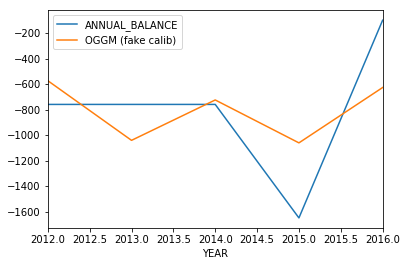

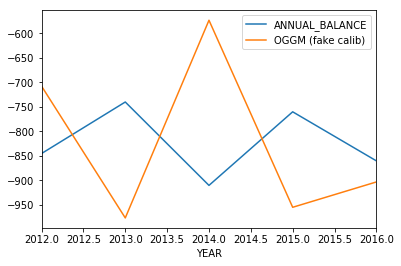

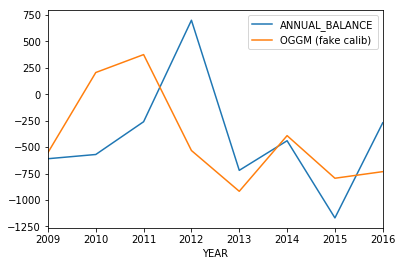

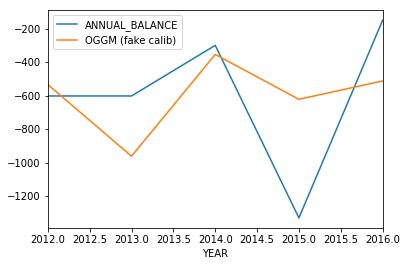

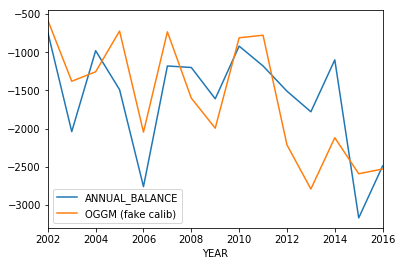

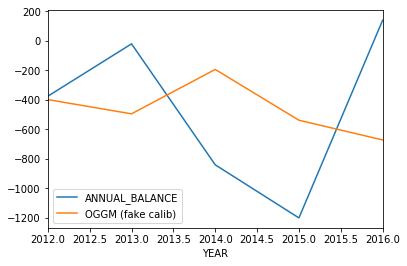

In [37]:
#Let's see how well our glaciers' mass-balance can be reproduced:
from oggm.core import massbalance

for i in range(6):
    gdir = gdirs[i]
    ref_df = gdir.get_ref_mb_data()
    mbmod = massbalance.PastMassBalance(gdir, check_calib_params=False)
    ref_df['OGGM (fake calib)'] = mbmod.get_specific_mb(fls=gdir.read_pickle('inversion_flowlines'), 
                                                    year=ref_df.index.values)
    ref_df[['ANNUAL_BALANCE', 'OGGM (fake calib)']].mean()
    ref_df[['ANNUAL_BALANCE', 'OGGM (fake calib)']].plot(); 
    
# Trying to create multi-panel  plot
# f, axarr = plt.subplots(2, 3, sharey=True, figsize=(14, 6))

# i, j = 0, 0
# for i in range(6):
#     gdir = gdirs[i]
#     ref_df = gdir.get_ref_mb_data()
#     mbmod = massbalance.PastMassBalance(gdir, check_calib_params=False)
#     ref_df['OGGM (fake calib)'] = mbmod.get_specific_mb(fls=gdir.read_pickle('inversion_flowlines'), 
#                                                     year=ref_df.index.values)   
#     ref_df[['ANNUAL_BALANCE', 'OGGM (fake calib)']].mean()
# #     ref_df[['ANNUAL_BALANCE', 'OGGM (fake calib)']].plot();
#     axarr[i, j].plot(ref_df[['ANNUAL_BALANCE', 'OGGM (fake calib)']]) 
    
#     j += 1

#     if val == 2: #changed to 2, 1 worked for 2x2 panel plot
#         i += 1
#         j = 0
        
#If I don't add check_calib_params=False I get the following error:   
#RuntimeError: You seem to use the glacier-wide mu* to compute the mass-balance although
#this glacier has different mu* for its flowlines. Set `check_calib_params=False` to 
#ignore this warning.


In [38]:
# Inversion tasks
execute_entity_task(tasks.prepare_for_inversion, gdirs)
# We use the default parameters for this run
execute_entity_task(tasks.mass_conservation_inversion, gdirs)
execute_entity_task(tasks.filter_inversion_output, gdirs)
    
# Compile output
log.info('Compiling output')
utils.compile_glacier_statistics(gdirs)

2019-06-15 12:51:35: oggm.workflow: Execute entity task prepare_for_inversion on 6 glaciers
2019-06-15 12:51:35: oggm.workflow: Execute entity task mass_conservation_inversion on 6 glaciers
2019-06-15 12:51:35: oggm.workflow: Execute entity task filter_inversion_output on 6 glaciers
2019-06-15 12:51:35: oggm.workflow: Execute entity task glacier_statistics on 6 glaciers


,rgi_region,rgi_subregion,name,cenlon,cenlat,rgi_area_km2,glacier_type,terminus_type,status,inv_volume_km3,...,flowline_mean_elev,flowline_max_elev,flowline_min_elev,flowline_avg_width,flowline_avg_slope,t_star,mu_star_glacierwide,mu_star_flowline_avg,mu_star_allsame,mb_bias
rgi_id,,,,,,,,,,,,,,,,,,,,,
RGI60-02.00147,02,02-03,,-117.137,49.7490,1.801,Glacier,Land-terminating,Glacier or ice cap,0.093953,...,2582.307727,2744.941982,2278.241370,1429.365079,0.259991,1978,112.298442,112.298442,True,2.249718
RGI60-02.01857,02,02-03,,-115.301,50.7108,2.585,Glacier,Land-terminating,Glacier or ice cap,0.217386,...,2669.340228,2795.232170,2485.948455,1104.700855,0.151482,1961,51.769973,51.770371,False,267.002466
RGI60-02.02171,02,02-03,,-116.930,50.8069,16.898,Glacier,Land-terminating,Glacier or ice cap,1.769939,...,2549.281085,3176.670958,1863.396933,1846.775956,0.193318,1999,99.193990,99.301286,False,-0.276860
RGI60-02.03688,02,02-03,,-117.434,51.2370,5.944,Glacier,Land-terminating,Glacier or ice cap,0.558082,...,2498.129918,2846.471014,2015.093692,1722.898551,0.162809,2001,141.504362,141.504362,True,-296.017854
RGI60-02.04264,02,02-03,,-117.710,51.4292,4.425,Glacier,Land-terminating,Glacier or ice cap,0.290188,...,2487.395544,2906.053572,2019.393974,1552.631579,0.306494,1961,162.312253,162.839814,False,675.610348
RGI60-02.07780,02,02-03,,-119.581,52.6705,6.490,Glacier,Land-terminating,Glacier or ice cap,0.419769,...,2335.618498,2788.856848,1723.604101,1257.751938,0.268448,2001,54.417966,54.433332,False,-69.062150


In [39]:
utils.compile_glacier_statistics(gdirs, inversion_only=True)

2019-06-15 12:52:25: oggm.workflow: Execute entity task glacier_statistics on 6 glaciers


,rgi_region,rgi_subregion,name,cenlon,cenlat,rgi_area_km2,glacier_type,terminus_type,status,inv_volume_km3,inv_thickness_m,vas_volume_km3,vas_thickness_m,dem_source,n_orig_centerlines,perc_invalid_flowline
rgi_id,,,,,,,,,,,,,,,,
RGI60-02.00147,02,02-03,,-117.137,49.7490,1.801,Glacier,Land-terminating,Glacier or ice cap,0.093953,52.166909,0.076350,42.393235,SRTM,2,0.000000
RGI60-02.01857,02,02-03,,-115.301,50.7108,2.585,Glacier,Land-terminating,Glacier or ice cap,0.217386,84.095011,0.125491,48.545796,SRTM,4,0.000000
RGI60-02.02171,02,02-03,,-116.930,50.8069,16.898,Glacier,Land-terminating,Glacier or ice cap,1.769939,104.742518,1.658641,98.156069,SRTM,5,0.000000
RGI60-02.03688,02,02-03,,-117.434,51.2370,5.944,Glacier,Land-terminating,Glacier or ice cap,0.558082,93.889975,0.394310,66.337403,SRTM,3,0.000000
RGI60-02.04264,02,02-03,,-117.710,51.4292,4.425,Glacier,Land-terminating,Glacier or ice cap,0.290188,65.579309,0.262791,59.387685,SRTM,4,0.031579
RGI60-02.07780,02,02-03,,-119.581,52.6705,6.490,Glacier,Land-terminating,Glacier or ice cap,0.419769,64.679390,0.444954,68.559979,SRTM,5,0.000000


Ice thickness for Conrad Glacier is now 104 m, why is this so much greater (88 m) than in the alternative DEM ipynb run?